# Step 1: Importing necessary libraries

In [2]:
#Importing libraries
import re
import pandas as pd

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

from pandas import DataFrame 
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
from sklearn.metrics import mean_squared_error

<Figure size 640x480 with 0 Axes>

# Step 2: Reading the Dataset

In [3]:
df = pd.read_json('Data/Luxury_Beauty.json', lines=True) 
df.head() 

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,2,3,True,"06 15, 2010",A1Q6MUU0B2ZDQG,B00004U9V2,D. Poston,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work,1276560000,NaN,NaN
1,5,14,True,"01 7, 2010",A3HO2SQDCZIE9S,B00004U9V2,chandra,"Believe me, over the years I have tried many, ...",Best hand cream ever.,1262822400,NaN,NaN
2,5,NaN,True,"04 18, 2018",A2EM03F99X3RJZ,B00004U9V2,Maureen G,Great hand lotion,Five Stars,1524009600,{'Size:': ' 3.5 oz.'},NaN
3,5,NaN,True,"04 18, 2018",A3Z74TDRGD0HU,B00004U9V2,Terry K,This is the best for the severely dry skin on ...,Five Stars,1524009600,{'Size:': ' 3.5 oz.'},NaN
4,5,NaN,True,"04 17, 2018",A2UXFNW9RTL4VM,B00004U9V2,Patricia Wood,The best non- oily hand cream ever. It heals o...,I always have a backup ready.,1523923200,{'Size:': ' 3.5 oz.'},NaN


In [4]:
#checking the shape of data
df.shape

(574628, 12)

# Step 3: Dataset pre-processing
> Performing product based colloborative filtering



In [5]:
#grouping by on product id (which is asin) on bases of count and mean
grp_count = df.groupby("asin", as_index=False).count()


#joining the dataframes
df_joined = pd.merge(df, grp_count, how='right', on=['asin'])
df_joined.head()

,overall_x,vote_x,verified_x,reviewTime_x,reviewerID_x,asin,reviewerName_x,reviewText_x,summary_x,unixReviewTime_x,...,vote_y,verified_y,reviewTime_y,reviewerID_y,reviewerName_y,reviewText_y,summary_y,unixReviewTime_y,style_y,image_y
0,2,3,True,"06 15, 2010",A1Q6MUU0B2ZDQG,B00004U9V2,D. Poston,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work,1276560000,...,40,582,582,582,582,581,582,582,567,3
1,5,14,True,"01 7, 2010",A3HO2SQDCZIE9S,B00004U9V2,chandra,"Believe me, over the years I have tried many, ...",Best hand cream ever.,1262822400,...,40,582,582,582,582,581,582,582,567,3
2,5,NaN,True,"04 18, 2018",A2EM03F99X3RJZ,B00004U9V2,Maureen G,Great hand lotion,Five Stars,1524009600,...,40,582,582,582,582,581,582,582,567,3
3,5,NaN,True,"04 18, 2018",A3Z74TDRGD0HU,B00004U9V2,Terry K,This is the best for the severely dry skin on ...,Five Stars,1524009600,...,40,582,582,582,582,581,582,582,567,3
4,5,NaN,True,"04 17, 2018",A2UXFNW9RTL4VM,B00004U9V2,Patricia Wood,The best non- oily hand cream ever. It heals o...,I always have a backup ready.,1523923200,...,40,582,582,582,582,581,582,582,567,3


In [6]:
#renaming columns
df_joined["num_reviewers"] = df_joined["reviewerID_y"]
df_joined["total_score"] = df_joined["overall_x"]
df_joined["review_summary"] = df_joined["summary_x"]

#making a new df containing just three columns
df_final = df_joined[['asin','review_summary','total_score',"num_reviewers"]]

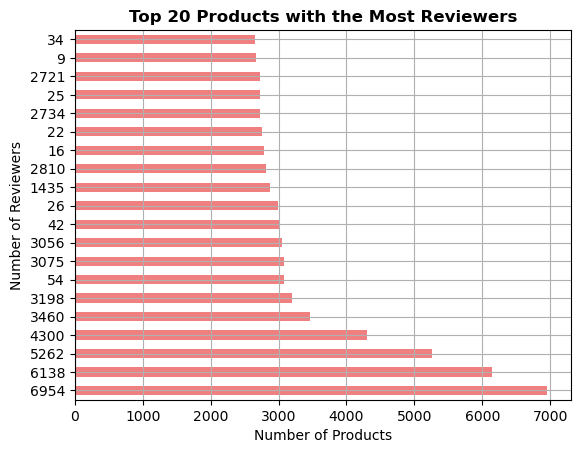

In [7]:

df_joined["num_reviewers"].value_counts()[:20].plot(kind='barh', grid=True , color='lightcoral')
plt.xlabel('Number of Products')
plt.ylabel('Number of Reviewers')
plt.title('Top 20 Products with the Most Reviewers', fontweight="bold")
plt.show()

In [10]:
#selecting reviews which were reviewed by more than 80 users
df_joined = df_joined.sort_values(by='num_reviewers', ascending=False)
df_joined_above_80 = df_joined[df_joined.num_reviewers >= 80]
df_joined_above_80.head()

,overall_x,vote_x,verified_x,reviewTime_x,reviewerID_x,asin,reviewerName_x,reviewText_x,summary_x,unixReviewTime_x,...,reviewerID_y,reviewerName_y,reviewText_y,summary_y,unixReviewTime_y,style_y,image_y,num_reviewers,total_score,review_summary
167975,5,NaN,True,"12 9, 2013",A5E2ZRLM50URD,B0013U0EYI,kris,Bought this for my grandmother and it is wond...,Amazing product!!!,1386547200,...,6954,6954,6944,6954,6954,0,146,6954,5,Amazing product!!!
164863,3,NaN,True,"01 13, 2013",A2PCJ19IEGIDAP,B0013U0EYI,JC,If you're balding then get this along with der...,Not bad,1358035200,...,6954,6954,6944,6954,6954,0,146,6954,3,Not bad
164852,5,NaN,False,"01 26, 2013",A1L7ZQEIAZDD7A,B0013U0EYI,Gnee,I love this. I have beginning thinning.. Can s...,40 yr old thinning part and bangs,1359158400,...,6954,6954,6944,6954,6954,0,146,6954,5,40 yr old thinning part and bangs
164853,5,NaN,True,"01 23, 2013",A3PCFE5HVTIS6T,B0013U0EYI,James V. Rohan Jr.,I cannot leave my house without using this pro...,Great Product,1358899200,...,6954,6954,6944,6954,6954,0,146,6954,5,Great Product
164854,5,NaN,False,"01 22, 2013",A2RI3JE1R69832,B0013U0EYI,John D Swan,I would recommend this to anyone who needs a p...,Great product,1358812800,...,6954,6954,6944,6954,6954,0,146,6954,5,Great product


Text(0.5, 1.0, 'Top 20 Products with the Most Reviewers (Reviewed by more than 80 users)')

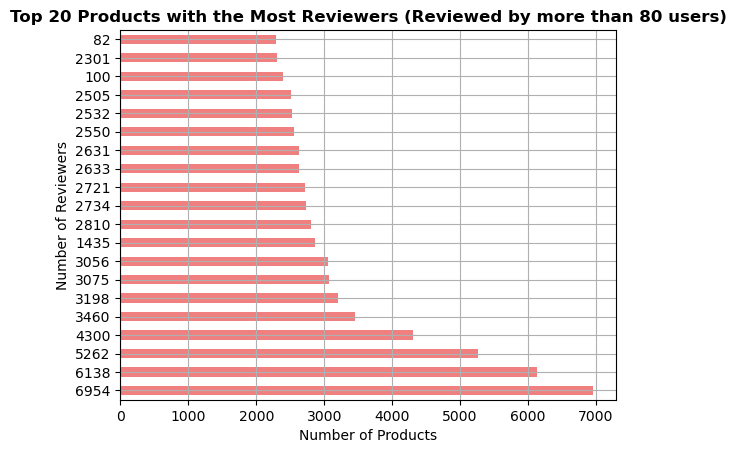

In [13]:
df_joined_above_80["num_reviewers"].value_counts()[:20].plot(kind='barh', grid=True , color='lightcoral')
plt.xlabel('Number of Products')  
plt.ylabel('Number of Reviewers')  
plt.title('Top 20 Products with the Most Reviewers (Reviewed by more than 80 users)', fontweight="bold")  

In [14]:
#making final product reviews dataset
df_product = df.groupby("asin", as_index=False).mean()
df_product_review = df_joined_above_80.groupby("asin")["review_summary"].apply(list)
df_product_review = pd.DataFrame(df_product_review)
df_product_review.to_csv("appliances_product_summary.csv")

/var/folders/dd/0k6q11nj127933sr8wm11nhw0000gn/T/ipykernel_63587/1709824845.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_product = df.groupby("asin", as_index=False).mean()


In [15]:
df_product_review.head()

,review_summary
asin,
B00004U9V2,"[Dent in can, It's long lasting, Wonderful, Th..."
B00005NDTD,"[I love the way this smells, Four Stars, Great..."
B00005V50B,"[Hard to find item, Well worth it...., Crazy, ..."
B000066SYB,"[Best Lotion I have ever used, Heavenly smell,..."
B000068DWY,"[amazing, nice, If it's good enough for Boomha..."


In [16]:
#merging
df_product_review = pd.read_csv("appliances_product_summary.csv")
df_product_review = pd.merge(df_product_review, df_product, on="asin", how='inner')


In [17]:
df_product_review = df_product_review[['asin','review_summary','overall']]
df_product_review.head()

,asin,review_summary,overall
0,B00004U9V2,"['Dent in can', ""It's long lasting"", 'Wonderfu...",4.623711
1,B00005NDTD,"['I love the way this smells', 'Four Stars', '...",4.862500
2,B00005V50B,"['Hard to find item', 'Well worth it....', 'Cr...",4.177419
3,B000066SYB,"['Best Lotion I have ever used', 'Heavenly sme...",4.493421
4,B000068DWY,"['amazing', 'nice', ""If it's good enough for B...",4.373596


In [18]:
df_ranges = pd.crosstab(df_product_review['asin'], pd.cut(df_product_review['overall'], [2, 2.5, 3.0, 3.5, 4.0, 4.5, 5]))
df_ranges.head()

overall,"(2.5, 3.0]","(3.0, 3.5]","(3.5, 4.0]","(4.0, 4.5]","(4.5, 5.0]"
asin,,,,,
B00004U9V2,0,0,0,0,1
B00005NDTD,0,0,0,0,1
B00005V50B,0,0,0,1,0
B000066SYB,0,0,0,1,0
B000068DWY,0,0,0,1,0


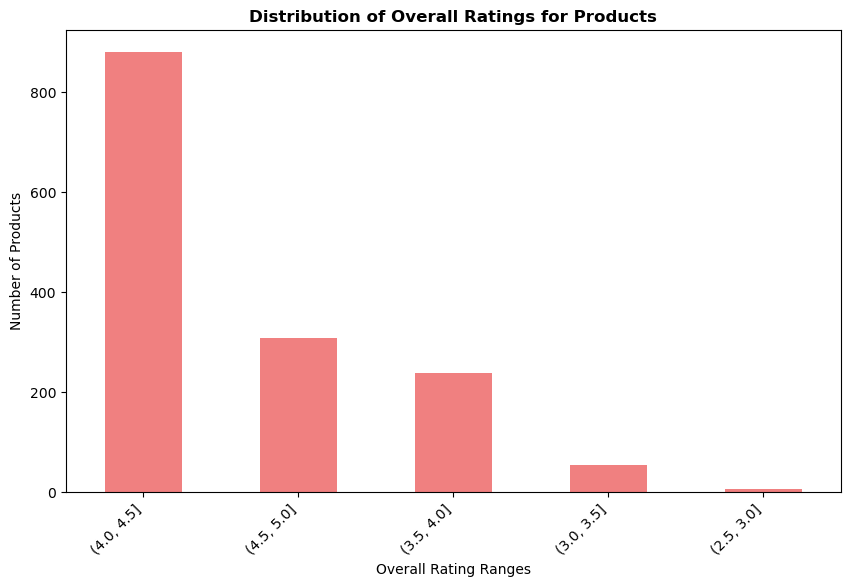

In [19]:
df_ranges.sum().sort_values(ascending=False).plot.bar(color='lightcoral', figsize=(10, 6))
plt.xlabel('Overall Rating Ranges')
plt.ylabel('Number of Products')
plt.title('Distribution of Overall Ratings for Products', fontweight="bold")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

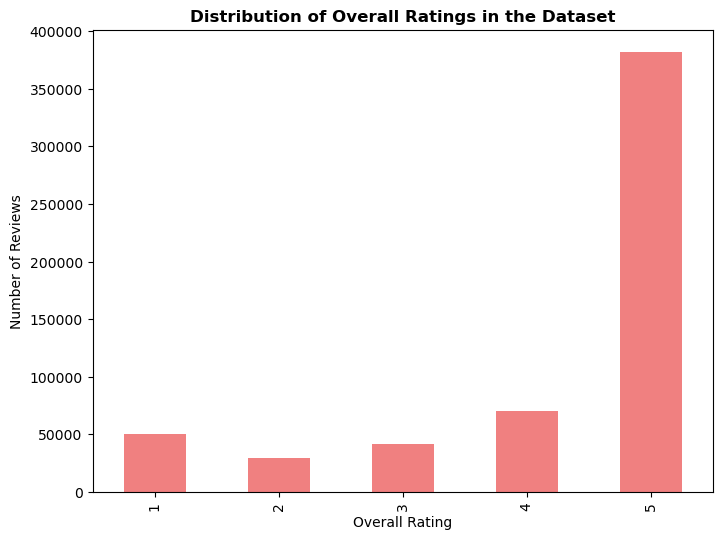

In [20]:
df['overall'].value_counts().sort_index().plot(kind='bar', color='lightcoral', figsize=(8, 6))
plt.xlabel('Overall Rating')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Overall Ratings in the Dataset', fontweight="bold")
plt.show()

# Step 4: Text Cleaning

In [21]:
#tokenizing text
reg = re.compile('[^a-z]+')
def cleanText(text):
    text = text.lower()
    text = reg.sub(' ', text).strip()
    return text

In [22]:
#drop duplicate rows
df_product_review["cleaned_review"] = df_product_review["review_summary"].apply(cleanText)
df_product_review = df_product_review.drop_duplicates(['overall'], keep='last')
df_product_review = df_product_review.reset_index()

In [23]:
#count vectorization
reviews = df_product_review["cleaned_review"] 
countVector = CountVectorizer(max_features = 200, stop_words='english') 
transformed_reviews = countVector.fit_transform(reviews) 

df_reviews = DataFrame(transformed_reviews.A, columns=countVector.get_feature_names_out())
df_reviews = df_reviews.astype(int)

In [24]:
#save 
df_reviews.to_csv("appliances_reviews.csv")

# Step 5: Train Test Split

In [26]:
X = np.array(df_reviews)
train_test_ratio = 0.9
size = int(np.floor(train_test_ratio * len(X)))
X_train = X[:size]
X_test = X[size:]

In [27]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X_train)
distances, indices = neighbor.kneighbors(X_train)

# Step 6: Finding related products
> Uses the Nearest Neighbors algorithm to find similar products based on their reviews.

In [29]:
#find most related products
for i in range(len(X_test)):
    product_test = neighbor.kneighbors([X_test[i]])
    related_products = product_test[1]

    related_product_1 = [item[0] for item in related_products]
    related_product_1 = str(related_product_1).strip('[]')
    related_product_1 = int(related_product_1)
    
    related_product_2 = [item[1] for item in related_products]
    related_product_2 = str(related_product_2).strip('[]')
    related_product_2 = int(related_product_2)
    
    print ("Based on product reviews, for ", df_product_review["asin"][len(X_train) + i] ," average rating is ",df_product_review["overall"][len(X_train) + i])
    print ("The first similar product is ", df_product_review["asin"][related_product_1] ," average rating is ",df_product_review["overall"][related_product_1])
    print ("The second similar product is ", df_product_review["asin"][related_product_2] ," average rating is ",df_product_review["overall"][related_product_2])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B00SVLSES0  average rating is  4.424107142857143
The first similar product is  B007WKCJRS  average rating is  4.069868995633188
The second similar product is  B00DHOROQ4  average rating is  4.15979381443299
-----------------------------------------------------------
Based on product reviews, for  B00SZF7ZW8  average rating is  3.409090909090909
The first similar product is  B0007ZG2DW  average rating is  4.091954022988506
The second similar product is  B00G993GUC  average rating is  3.8536585365853657
-----------------------------------------------------------
Based on product reviews, for  B00T07GQ3E  average rating is  4.122641509433962
The first similar product is  B002D48QRU  average rating is  4.201612903225806
The second similar product is  B001K9X9W6  average rating is  4.704545454545454
-----------------------------------------------------------
Based on product reviews, for  B00T5DZ4C2  average rating is  3.0934065934065935
The first similar prod

In [30]:
y_train = df_product_review["overall"][:len(X_train)].apply(np.ceil)
y_test = df_product_review["overall"][len(X_train):len(X_train)+len(X_test)].apply(np.ceil)

Over Sampling

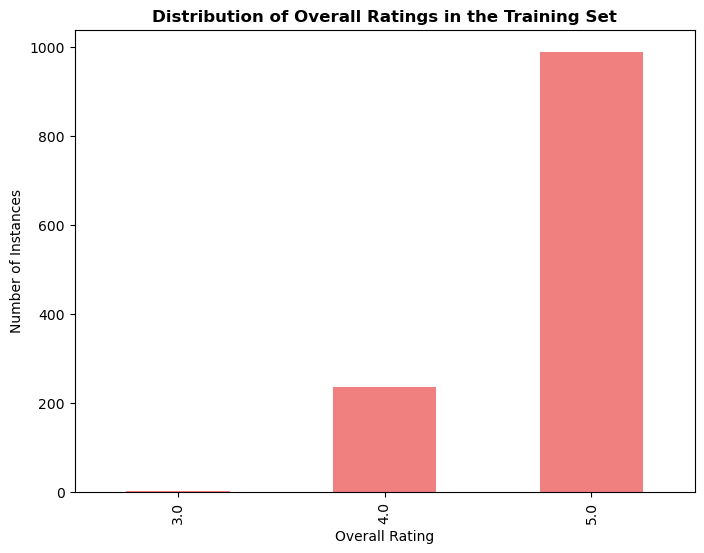

In [31]:
#before over sampling
y_train.value_counts().sort_index().plot(kind='bar', color='lightcoral', figsize=(8, 6))
plt.xlabel('Overall Rating')
plt.ylabel('Number of Instances')
plt.title('Distribution of Overall Ratings in the Training Set', fontweight="bold")
plt.show()


### Apply kNN algorithm 

In [32]:
clf = neighbors.KNeighborsClassifier(3, weights='distance')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         3
         4.0       0.52      0.26      0.34        43
         5.0       0.73      0.91      0.81        91

    accuracy                           0.69       137
   macro avg       0.42      0.39      0.38       137
weighted avg       0.65      0.69      0.65       137



In [33]:
print ("accuracy_score", accuracy_score(y_test, pred))
print("mean_squared_error" , mean_squared_error(y_test, pred))

accuracy_score 0.6861313868613139
mean_squared_error 0.3357664233576642


In [34]:
cluster = df.groupby("overall")["summary"].apply(list)
cluster = pd.DataFrame(cluster)
cluster.to_csv("cluster.csv")
cluster1 = pd.read_csv("cluster.csv")
cluster1["summaryClean"] = cluster1["summary"].apply(cleanText)

In [35]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=30, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

Generates a word cloud for reviews with a specific score.

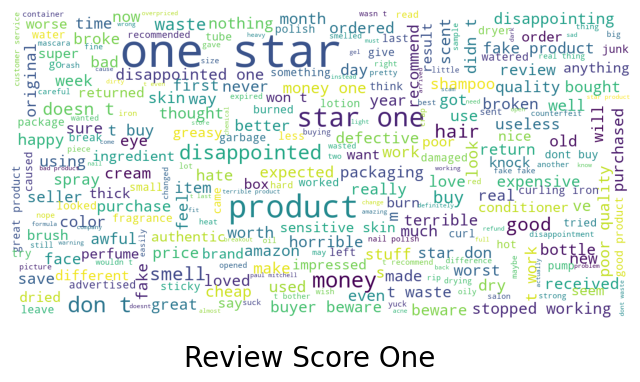

In [37]:
show_wordcloud(cluster1["summaryClean"][0], title = "Review Score One")

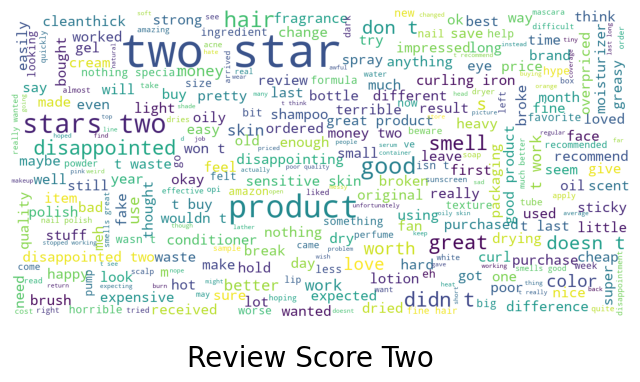

In [38]:
show_wordcloud(cluster1["summaryClean"][1], title = "Review Score Two")

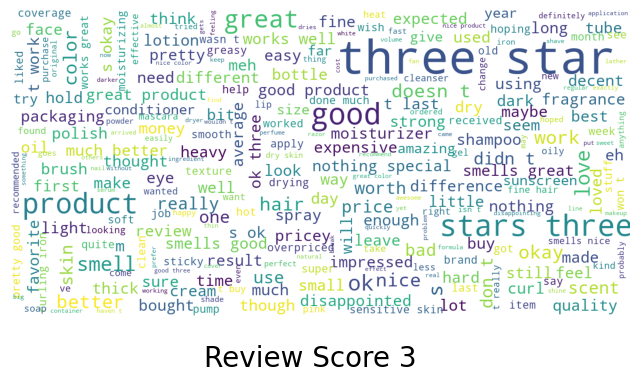

In [39]:
show_wordcloud(cluster1["summaryClean"][2], title = "Review Score 3")

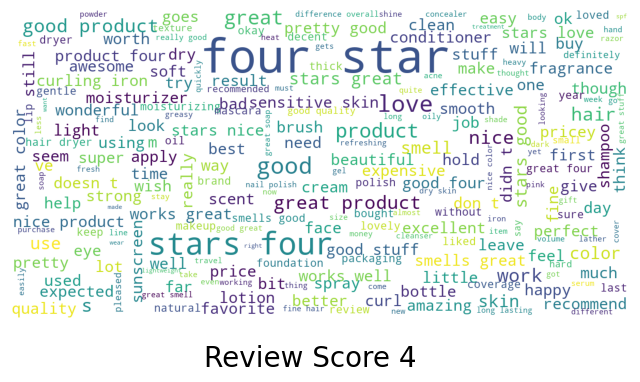

In [40]:
show_wordcloud(cluster1["summaryClean"][3], title = "Review Score 4")

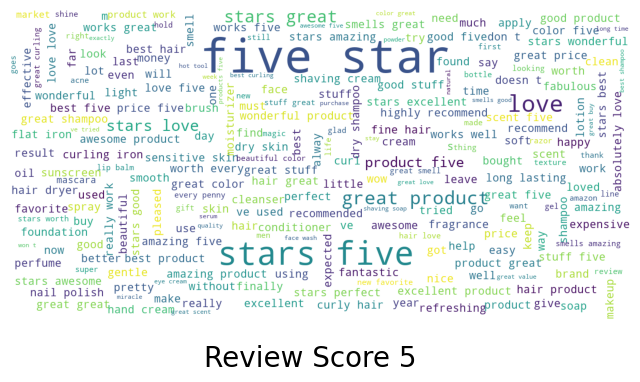

In [41]:
show_wordcloud(cluster1["summaryClean"][4], title = "Review Score 5")

Evaluates the error rate for different values of k in K-Nearest Neighbors.

In [42]:
errors = []
K = range(1,10)
for k in K:
    model  = neighbors.KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    errors.append(mean_squared_error(y_test, pred))

Text(0, 0.5, 'Error Rate')

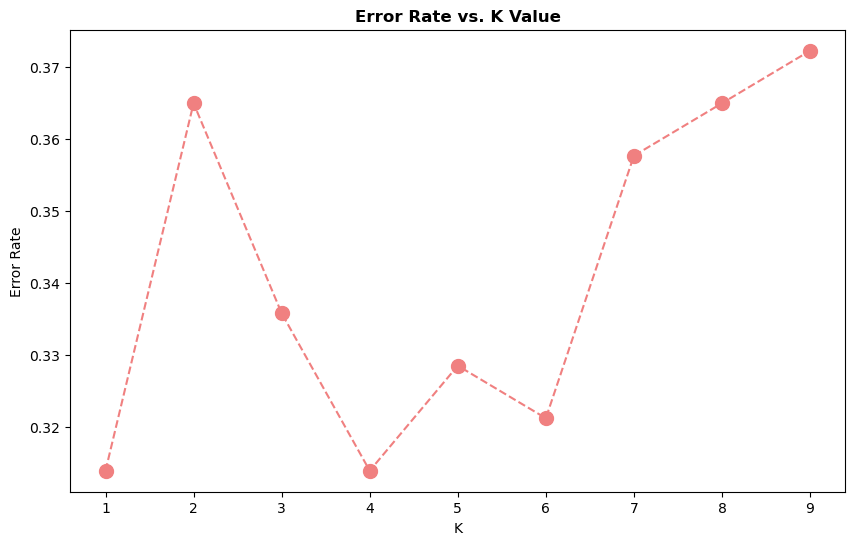

In [43]:
plt.figure(figsize=(10,6))
plt.plot(range(1,10), errors, color='lightcoral', linestyle='dashed', marker='o', markersize=10)
plt.title('Error Rate vs. K Value', fontweight="bold")
plt.xlabel('K')
plt.ylabel('Error Rate')

In [44]:
clf = neighbors.KNeighborsClassifier(6, weights='distance')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print(classification_report(y_test, pred))
print ("Accuracy: ",accuracy_score(y_test, pred))
print("MSE: ",mean_squared_error(y_test, pred))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         3
         4.0       0.56      0.21      0.31        43
         5.0       0.71      0.95      0.81        91

    accuracy                           0.69       137
   macro avg       0.42      0.38      0.37       137
weighted avg       0.65      0.69      0.63       137

Accuracy:  0.6934306569343066
MSE:  0.3284671532846715


/Users/fannypatel/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fannypatel/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fannypatel/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
